In [22]:
import arviz as az
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.integrate as integrate

In [23]:
#https://cp.copernicus.org/articles/17/1065/2021/cp-17-1065-2021-supplement.pdf
pmip=pd.read_csv("PMIP.dat",delim_whitespace=True)

In [24]:
sheet_id="1EjugdAQ4ACrN_oJPsOWDWr0tf4mNZTRcTuejAwivTx8"
sheet_name = "Temperature"
url_t = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
LGM_temperature=pd.read_csv(url_t)

sheet_name = "Forcing"
url_f = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
LGM_forcing=pd.read_csv(url_f)

In [25]:
LGM_forcing

,Quantity,Mean,Sigma,Reference,Model,Other
0,Rice,-3.79,NaN,https://royalsocietypublishing.org/doi/full/10...,CCSM4,PMIP3
1,Rice,-4.90,NaN,https://royalsocietypublishing.org/doi/full/10...,IPSL-CM5A-LR,PMIP3
2,Rice,-5.20,NaN,https://royalsocietypublishing.org/doi/full/10...,MIROC-ESM,PMIP3
3,Rice,-4.57,NaN,https://royalsocietypublishing.org/doi/full/10...,MPI-ESM-P,PMIP3
4,Rice,-3.62,NaN,https://royalsocietypublishing.org/doi/full/10...,MRI-CGCM3,PMIP3
5,Rice,-2.59,NaN,https://www.nature.com/articles/nclimate1456,CCSM3,PMIP4
6,Rice,-2.66,NaN,https://www.nature.com/articles/nclimate1456,CMRM,PMIP4
7,Rice,-3.23,NaN,https://www.nature.com/articles/nclimate1456,HadCM3M2,PMIP4
8,Rice,-3.41,NaN,https://www.nature.com/articles/nclimate1456,HadCM3M2 v,PMIP4
9,Rice,-3.48,NaN,https://www.nature.com/articles/nclimate1456,IPSL-CM4,PMIP4


In [4]:
#Studies with reported standard deviations
y=LGM_temperature[(LGM_temperature.Other!="PMIP4") & (LGM_temperature.Other!="PMIP3")].Mean.values
s=LGM_temperature[(LGM_temperature.Other!="PMIP4") & (LGM_temperature.Other!="PMIP3")].Sigma.values

#PMIP model values
pmip4=LGM_temperature[(LGM_temperature.Other=="PMIP4")].Mean.values
y=np.append(y,np.average(pmip4))
s=np.append(s,np.std(pmip4))

pmip3=LGM_temperature[(LGM_temperature.Other=="PMIP3")].Mean.values
y=np.append(y,np.average(pmip3))
s=np.append(s,np.std(pmip3))

In [5]:
with pm.Model() as tierneyprior:
    #priors on latent underlying mean and inter-study spread (random effects model, tau=0 for fixed effects)
    μ=pm.Normal("μ",-6.1,sd=0.2)
    #τ=pm.InverseGamma("τ",1,0.15)
    τ=pm.Uniform("τ",0,100)
    θ=pm.Normal('θ',μ,sd=τ,shape=len(y))
    obs=pm.Normal("obs",θ,sd=s,observed=y)
    
with pm.Model() as tierneyprior_fixed:
    #priors on latent underlying mean and inter-study spread (random effects model, tau=0 for fixed effects)
    μ=pm.Normal("μ",-6.1,sd=0.2)
    #τ=pm.InverseGamma("τ",1,0.15)
   # τ=pm.Uniform("τ",0,100)
   # θ=pm.Normal('θ',μ,sd=τ,shape=len(y))
    obs=pm.Normal("obs",μ,sd=s,observed=y)
    
with pm.Model() as broadprior:
    #priors on latent underlying mean and inter-study spread (random effects model, tau=0 for fixed effects)
    μ=pm.Normal("μ",0,sd=100)
    #τ=pm.InverseGamma("τ",1,0.15)
    τ=pm.Uniform("τ",0,100)
    θ=pm.Normal('θ',μ,sd=τ,shape=len(y))
    obs=pm.Normal("obs",θ,sd=s,observed=y)
    
    
with pm.Model() as broadprior_fixed:
    #priors on latent underlying mean and inter-study spread (random effects model, tau=0 for fixed effects)
    μ=pm.Normal("μ",0,sd=100)
    #τ=pm.InverseGamma("τ",1,0.15)
   # τ=pm.Uniform("τ",0,100)
   # θ=pm.Normal('θ',μ,sd=τ,shape=len(y))
    obs=pm.Normal("obs",μ,sd=s,observed=y)    

In [6]:
with tierneyprior:
    tierneytrace=pm.sample(return_inferencedata=True)
with tierneyprior_fixed:
    tierney_fixed_trace=pm.sample(return_inferencedata=True)
with broadprior:
    broadtrace=pm.sample(return_inferencedata=True)
with broadprior_fixed:
    broadtrace_fixed=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, τ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8846983060955458, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, τ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<AxesSubplot:title={'center':'μ'}, ylabel='Density'>

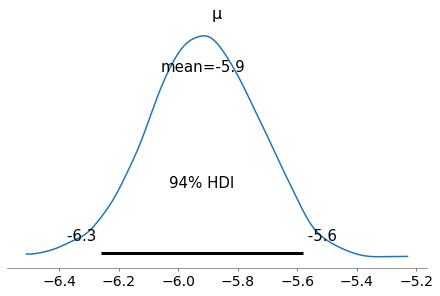

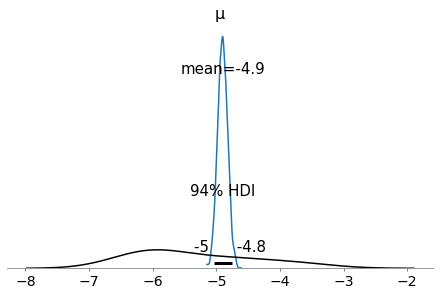

In [7]:
#If our priors are EXACTLY the tierney estimates and we believe there to be substantial random spread among studies, we don't really budge
az.plot_posterior(tierneytrace.posterior.μ)
#If our priors are the Tierney estimates and we believe all studies to be measuring the same thing, T20 is just an outlier
az.plot_posterior(tierney_fixed_trace.posterior.μ)
#sns.kdeplot(np.random.normal(-5,1,100000),c="r")
sns.kdeplot(y,c="k")

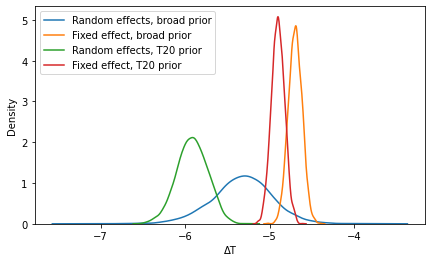

In [8]:
#Meta analysis of temperature
plt.figure(figsize=(7,4))
sns.kdeplot(broadtrace.posterior.μ.values.flatten(),label="Random effects, broad prior")
sns.kdeplot(broadtrace_fixed.posterior.μ.values.flatten(),label="Fixed effect, broad prior")
sns.kdeplot(tierneytrace.posterior.μ.values.flatten(),label="Random effects, T20 prior")
sns.kdeplot(tierney_fixed_trace.posterior.μ.values.flatten(),label="Fixed effect, T20 prior")
plt.xlabel("ΔT")
plt.legend()
plt.savefig("FIGS/meta.png")

In [9]:
#Highest posterior density intervals
az.hdi(tierneytrace.posterior.μ,hdi_prob=.90).μ.values

array([-6.2112926 , -5.61538728])

In [10]:
pmip3_rice=LGM_forcing[(LGM_forcing.Other=="PMIP3") &(LGM_forcing.Quantity=="Rice") ].Mean.values
pmip4_rice=LGM_forcing[(LGM_forcing.Other=="PMIP4") &(LGM_forcing.Quantity=="Rice") ].Mean.values

dust_estimates=LGM_forcing[LGM_forcing.Quantity=="Rdust"].Mean.values
insolation_estimates=LGM_forcing[LGM_forcing.Quantity=="Rinsolation"].Mean.values
ghg_estimates=LGM_forcing[LGM_forcing.Quantity=="Rghg"].Mean.values
ice_estimates=np.append(pmip3_rice,pmip4_rice)

In [11]:
with pm.Model() as nonGHGforcings:
    μ_ice = pm.Normal("μ_ice",0,10)
    σ_ice = pm.HalfNormal('σ_ice', sd=10)
    F_ice = pm.Normal('F_ice', mu=μ_ice, sd=σ_ice, observed=ice_estimates)
    
    μ_dust = pm.Normal("μ_dust",0,10)
    σ_dust = pm.HalfNormal('σ_dust', sd=10)
    F_dust = pm.Normal('F_dust', mu=μ_dust, sd=σ_dust, observed=dust_estimates)
    
    μ_insolation = pm.Normal("μ_insolation",0,10)
    σ_insolation = pm.HalfNormal('σ_insolation', sd=10)
    F_insolation = pm.Normal('F_insolation', mu=μ_insolation, sd=σ_insolation, observed=insolation_estimates)
    
    total=μ_dust+μ_ice+μ_insolation
        
#     μ_GHG = pm.Normal("μ_GHG",0,10)
#     σ_GHG = pm.HalfNormal('σ_GHG', sd=10)
#     F_GHG = pm.Normal('F_GHG', mu=μ, sd=σ, observed=GHG_estimates)
    
    
with nonGHGforcings:
    testtrace=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_insolation, μ_insolation, σ_dust, μ_dust, σ_ice, μ_ice]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


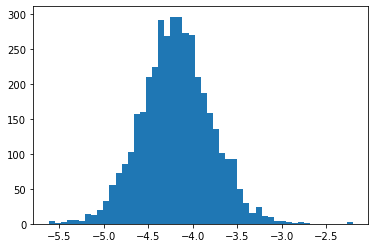

In [12]:
non_GHG_forcings_posterior=(testtrace.posterior.μ_ice+testtrace.posterior.μ_insolation+testtrace.posterior.μ_dust).values.flatten()
tmp=plt.hist(non_GHG_forcings_posterior,50)


In [27]:
az.hdi(non_GHG_forcings_posterior,hdi_prob=.9)

array([-4.81862303, -3.53557729])

In [13]:
#from S20
vegetation_forcing=np.random.normal(-1.1,0.6/1.64,len(non_GHG_forcings_posterior))
GHG_forcing=np.random.normal(-2.27+-0.57 +-0.28,0.26,len(non_GHG_forcings_posterior))
LGM_forcing=non_GHG_forcings_posterior+GHG_forcing+vegetation_forcing
muF_meta=np.average(LGM_forcing)
sigF_meta=np.std(LGM_forcing)

In [15]:
muT_meta=np.average(broadtrace.posterior.μ)
sigT_meta=np.std(broadtrace.posterior.μ.values.flatten())


In [16]:
def PT(T):
    
    muT= muT_meta
    sigT=sigT_meta
    
    return np.exp(-0.5*(T-muT)**2/sigT**2)*1/(np.sqrt(2*np.pi)*sigT)
def PF(F):
    muF=muF_meta
    sigF=sigF_meta
    

    #muT=-5.
    #sigT=1.
    return np.exp(-0.5*(F-muF)**2/sigF**2)*1/(np.sqrt(2*np.pi)*sigF)
  

In [17]:
lams=np.linspace(-5,5,1000)
alphas=np.linspace(-1,1,500)
lamshape=len(lams)
alphashape=len(alphas)

In [18]:
def LGM_likelihood_meta(lam,alpha):
    
    #integrand=lambda x: PF(2*alpha*x**2- lam*x)*PT(x,tempfrom=tempfrom)* np.sqrt(1+(4*alpha*x-lam)**2)
    integrand=lambda x: PF(-alpha/2.*x**2- lam*x)*PT(x)* np.sqrt(1+(-alpha*x+-lam)**2)

    return integrate.quad(integrand,-np.inf,np.inf)[0]

In [20]:

LGM0=np.array([LGM_likelihood_meta(x,0) for x in lams])


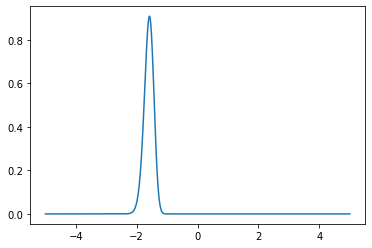

In [21]:
plt.plot(lams,LGM0)

In [276]:
generate_joint_PDF=False
pickle_it=False
if generate_joint_PDF:
    JPDF_meta=np.zeros((lamshape,alphashape))
    
    for i in range(lamshape):
        for j in range(alphashape):
            JPDF_meta[i,j]=LGM_likelihood_meta(lams[i],alphas[j])

   

In [277]:
import datetime
import pickle
if pickle_it:
    today=datetime.date.today().strftime("%m%d%Y")
    with open("PICKLED/LGM_JPDF_meta_"+today+".pkl","wb") as picklefile:
        pickle.dump(JPDF_meta,picklefile)